In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import copy

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from model import Symmetric, DeepSets, KNN, KK
from sample import generate_data, generate_narrow_data
from train import train
from evaluate import generalization_error, cross_validate

%matplotlib inline

In [2]:
####NOTE: you've edited the compare_models function here, and the nature of the objectives here,
#### and the data distribution in sample.py.  Be aware of this when you update to github again

In [3]:
#For smooth neuron experiment, it's only fair to S2 if the neuron is drawn from the same random features

def smooth_neuron_weight_init(model, objective):
    if objective.__name__ == "smooth_neuron":
        with torch.no_grad():
            model.phi.fc.weight = objective.__network__.phi.fc.weight
            model.phi.fc.weight.requires_grad = False        
            model.phi.fc.weight.div_(torch.norm(model.phi.fc.weight, dim = 1, keepdim = True))

In [19]:
def compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, objective, narrow, verbose = True, log_plot = False, scaleup = False):
    print("currently", objective.__name__)
    
    bias_first = "neuron" in objective.__name__

    c = 1 if not scaleup else 2

    f1 = Symmetric(input_dim, c * hidden_dim, hidden_dim)
    f2 = KNN(input_dim, c * hidden_dim, hidden_dim)
    f3 = KK(input_dim, c * hidden_dim, hidden_dim)

    f1.__name__ = "S1"
    f2.__name__ = "S2"
    f3.__name__ = "S3"

    models = [f1, f2, f3]
    lambs = [0., 1e-6, 1e-4, 1e-2]
    N_list = np.arange(2, N_max + 16)

    for model in models:
        x, y = generate_data(N_max, batch_size, input_dim, objective, narrow, bias_first)
        
        smooth_neuron_weight_init(model, objective)
        
        cv_models = cross_validate(model, x, y, iterations, lambs, verbose)
        
        validation_errors = np.zeros_like(lambs)
        for i, cv_model in enumerate(cv_models):
            validation_errors[i] = generalization_error([N_max], 1000, input_dim, cv_model, objective, narrow, bias_first)[0]
        
        i = np.argmin(validation_errors)
        lamb = lambs[i]
            
        runs = 10
        run_errors = np.zeros((runs, len(N_list)))
        for i in range(runs):
            x, y = generate_data(N_max, batch_size, input_dim, objective, narrow, bias_first)
            model_copy = copy.deepcopy(model)
            model_copy.reinit()
            smooth_neuron_weight_init(model_copy, objective)
            
            train(model_copy, x, y, iterations, lamb)
            errors = generalization_error(N_list, 1000, input_dim, model_copy, objective, narrow, bias_first)
            run_errors[i] = np.array(errors)
        
        mean_error = np.mean(run_errors, axis = 0)
        std_error = np.std(run_errors, axis = 0)
        if verbose:
            print("performance of ", model.__name__, " on ", objective.__name__)
            print("lamb =", lamb)
            print(mean_error)
            print(std_error)
            
            
        narrow_str = "Narrow" if narrow else "Wide"
        scaleup_str = "scaleup" if scaleup else ""
        save_str = model.__name__ + "_" + objective.__name__ + "_" + narrow_str + "_" + str(input_dim) + scaleup_str
        save_dir = "saved_data/"
            
        np.save(save_dir + save_str + "_mean", mean_error)
        np.save(save_dir + save_str + "_std", std_error)
        
        if log_plot:
            plt.semilogy(N_list, mean_error, label = model.__name__)
        else:
            plt.plot(N_list, mean_error, label = model.__name__)
        plt.fill_between(N_list, mean_error - std_error, mean_error + std_error, alpha = 0.2)

    
    plt.legend()
    plt.ylim([1e-5, 1e-1]) 

    plt.xlabel("N")
    plt.ylabel("Mean Square Error")
    narrow_str = "Narrow" if narrow else "Wide"
    plt.title(narrow_str + " generalization for " + objective.__name__)
    scaleup_str = "scaleup" if scaleup else ""
#     plt.savefig("plots_high_dim/" + objective.__name__ + "_" + narrow_str + "_" + str(input_dim) + scaleup_str)
    plt.show()
    plt.close()

In [20]:
#For the rest of the notebook
input_dim = 10
hidden_dim = 100

In [21]:
mean = lambda x: np.mean(norm(x, axis = 2), axis = 1, keepdims = True)

median = lambda x: np.median(norm(x, axis = 2), axis = 1, keepdims = True)

maximum = lambda x: np.max(norm(x, axis = 2), axis = 1, keepdims = True)

lamb = 0.1
softmax = lambda x: lamb * np.log(np.mean(np.exp(norm(x, axis = 2) / lamb), axis = 1, keepdims = True))

second = lambda x: np.sort(norm(x, axis = 2), axis = 1)[:,-2].reshape(-1,1)

In [8]:
### May need to sample several neurons to find one that isn't degenerate on the domain


teacher = Symmetric(input_dim, hidden_dim, 1)
torch.nn.init.uniform_(teacher.phi.fc.weight, a = -1.0, b = 1.0)
teacher.eval()

def neuron(x):
    x = torch.from_numpy(x).float()
    y = teacher(x)
    return y.data.numpy().reshape(-1, 1)

neuron.__network__ = teacher

x, y = generate_narrow_data(3, 15, input_dim, neuron, bias_first = True)
print(y.data.numpy().flatten())

[-1.2489308  -0.55221474 -0.255867    0.         -0.27635792 -0.5203377
 -0.9401208   0.          0.          0.          0.          0.
 -1.0905515  -1.2536428   0.        ]


In [13]:
### May need to sample several neurons to find one that isn't degenerate on the domain

smooth_teacher = Symmetric(input_dim, hidden_dim, 1)
torch.nn.init.uniform_(smooth_teacher.rho.fc1.weight,a = -1.0, b = 1.0)  #####NOTE WE CHANGED THIS DISTRIBUTION
smooth_teacher.eval()

def smooth_neuron(x):
    x = torch.from_numpy(x).float()
    y = smooth_teacher(x)
    return y.data.numpy().reshape(-1, 1)

smooth_neuron.__network__ = smooth_teacher

x, y = generate_narrow_data(3, 15, input_dim, smooth_neuron, bias_first = True)
print(y.data.numpy().flatten())

[1.0168916  0.         0.         0.         0.         0.
 0.303104   0.         0.         0.         0.         0.
 0.24400099 0.1610713  0.        ]


In [14]:
neuron.__name__ = "neuron"
smooth_neuron.__name__ = "smooth_neuron"
maximum.__name__ = "maximum"
softmax.__name__ = "softmax"
median.__name__ = "median"
mean.__name__ = "mean"
second.__name__ = "second"

In [15]:
###############################################

In [16]:
#Run to generate plots in Figure 1:

N_max = 4

iterations = 5000
batch_size = 100

currently neuron
check for overfitting power of S1
lowest loss: 2.3592239935029067e-17
performance of  S1  on  neuron
lamb = 0.0
[0.0313372  0.02320848 0.01844053 0.01463218 0.01271227 0.01165044
 0.01048303 0.00949042 0.00894942 0.00824726 0.00771566 0.00744136
 0.00706604 0.00676031 0.00652702 0.00596006 0.0058357  0.00575356]
[0.00667331 0.00542372 0.00438259 0.00330617 0.00305607 0.00262148
 0.00232525 0.00182734 0.00203354 0.00181307 0.0016339  0.00166762
 0.00147218 0.0016224  0.00123551 0.00122315 0.00121128 0.00135084]
check for overfitting power of S2
lowest loss: 1.215961498157725e-10
performance of  S2  on  neuron
lamb = 1e-06
[0.04932982 0.03334675 0.02616069 0.02229099 0.02005945 0.01761758
 0.01647382 0.01514012 0.01413682 0.01359442 0.01268803 0.01224982
 0.01187669 0.01136412 0.01088754 0.01066128 0.01036528 0.01007526]
[0.00678627 0.00407967 0.00316965 0.00255801 0.0024407  0.00221693
 0.00213612 0.00226593 0.00226384 0.0024651  0.00247699 0.00220223
 0.00290223 0.0024

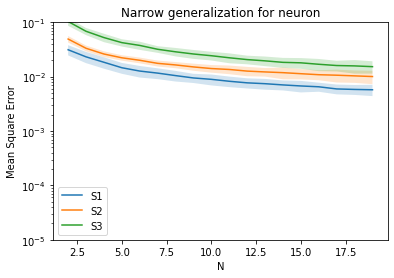

In [22]:
compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , neuron, narrow = True, log_plot = True)

currently smooth_neuron
check for overfitting power of S1
lowest loss: 2.0652880447502575e-13
performance of  S1  on  smooth_neuron
lamb = 1e-06
[0.0776254  0.04368634 0.02925095 0.02157833 0.01402527 0.01101034
 0.00825315 0.0058093  0.00467506 0.00382195 0.00333082 0.00276068
 0.00225167 0.00193199 0.00177994 0.00140179 0.00117096 0.00100774]
[0.01093138 0.00785907 0.00440155 0.00463918 0.00295685 0.00177985
 0.0013454  0.00069721 0.00082838 0.00045119 0.00065987 0.0003792
 0.00037405 0.00061871 0.00045755 0.00025166 0.00037903 0.00022086]
check for overfitting power of S2
lowest loss: 1.286933724031769e-07
performance of  S2  on  smooth_neuron
lamb = 0.0001
[0.08043935 0.04519271 0.02743737 0.02016411 0.01369115 0.01031903
 0.00750569 0.00571391 0.00471678 0.0042519  0.00299761 0.00251542
 0.00216963 0.00186806 0.0015398  0.00123981 0.00109652 0.00099081]
[0.01828645 0.0104201  0.00610021 0.00320958 0.00327255 0.00186343
 0.00170806 0.00099897 0.00130151 0.0006975  0.00065135 0.0003

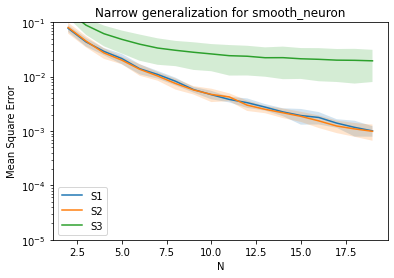

In [18]:
compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , smooth_neuron, narrow = True, log_plot = True)

In [ ]:
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, mean, narrow = False, log_plot = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , mean, narrow = True, log_plot = True)

# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, median, narrow = False, log_plot = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , median, narrow = True, log_plot = True)

# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, maximum, narrow = False, log_plot = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , maximum, narrow = True, log_plot = True)

# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, softmax, narrow = False, log_plot = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , softmax, narrow = True, log_plot = True)

# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, second, narrow = False, log_plot = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , second, narrow = True, log_plot = True)

# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, neuron, narrow = False, log_plot = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , neuron, narrow = True, log_plot = True)

# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, smooth_neuron, narrow = False, log_plot = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , smooth_neuron, narrow = True, log_plot = True)

In [ ]:
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , neuron, narrow = True, log_plot = True, scaleup = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , smooth_neuron, narrow = True, log_plot = True, scaleup = True)

# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , neuron, narrow = True, log_plot = True, scaleup = False)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , smooth_neuron, narrow = True, log_plot = True, scaleup = False)

In [ ]:
###############################################